# Adding inhibition to stable networks to find maximum ratio of spike pulse propagation speeds
Here, we add inhibition, modeled as global Poisson input to the chain, to stable networks identified in D2a and D2b.

In [1]:
%matplotlib inline
from copy import deepcopy as copy
import matplotlib.gridspec as gridspec
import matplotlib.pyplot as plt
import numpy as np
from scipy import stats
import os
import sys

from aux import Generic
from disp import set_font_size, get_spaced_colors
from ntwk import LIFNtwkG, join_w

cc = np.concatenate

# PARAMS
## NEURON AND NETWORK MODEL
M = Generic(
    # Excitatory membrane
    C_M_E=1e-6,  # membrane capacitance
    G_L_E=.1e-3,  # membrane leak conductance (T_M (s) = C_M (F/cm^2) / G_L (S/cm^2))
    E_L_E=-.06,  # membrane leak potential (V)
    V_TH_E=-.05,  # membrane spike threshold (V)
    T_R_E=.002,  # refractory period (s)
    
    # Inhibitory membrane
    #C_M_I=1e-6,
    #G_L_E=.1e-3, 
    #E_L_I=-.06,
    #V_TH_E=-.05,
    #T_R_I=.002,
    
    # syn rev potentials and decay times
    E_E=0, E_I=-.08, E_A=-0.1, T_E=.002, T_I=.002, T_A=0.01,

    # NTWK ARCHITECTURE
    N_L=160,  # num chain links
    N_L_E=30,  # num E nrns per chain link
    N_I=200, # num I nrns (unused)
    
    W_R_E_E_L=1.4e-5,  # E-E recurrent cxns w/in chain link
    W_R_E_E_F=0.01e-3,  # E-E feed-forward from one link to next
    
    W_A=.05e-3, # adaptation weight for all neurons
    
    W_R_E_I=0,  # recurrent I->E weights
    W_R_I_E=0,  # recurrent E->I weights
    
    W_U_E_I=1e-4,  # upstream inh weights to E chain
    W_U_E_E=0,  # upstread exc weights to E chain
    
    P_CXN_E_E=.6,
    P_CXN_E_I=1.,
    
    # OTHER INPUTS
    SGM_N=.5e-9,  # noise level (A*sqrt(s))
    I_EXT_B=0,  # additional baseline current input
)

M.N_E = M.N_L * M.N_L_E
M.N_N = M.N_E + M.N_I
M.X_E = cc([np.repeat(cl, M.N_L_E) for cl in range(M.N_L)])

## SMLN
S = Generic(RNG_SEED=0, DT=.0005)

print('T_M_E =', 1000*M.C_M_E/M.G_L_E, 'ms')  # E cell membrane time constant (C_m/g_m)

T_M_E = 10.0 ms


# Redefine functions for simulating a single set of parameters
Specific comments on this code to be found in notebook D1

### Redefine helper functions from D2a and D2b

In [2]:
def rand_bin_array_with_percentage_ones(l, num_ones):
    a = np.zeros(l)
    a[:num_ones] = 1
    np.random.shuffle(a)
    return a


def sprs_mat_with_rand_percent_cnxns(shape, row_percent):
    num_ones = int(row_percent * shape[0])
    stacked = np.stack([rand_bin_array_with_percentage_ones(shape[0], num_ones) for i in range(shape[1])])
    return stacked

### Helper functions for defining connectivity

Recurrent neurons: N = N_E + N_I.

Upstream neurons: one link's worth of E neurons (for trigger) + N

In [3]:
# see D1 for specific comments on these functions

## E-E weights
def make_w_r_e(m):
    w_r_e = np.zeros([m.N_N]*2)

    w_r_e_e = m.W_R_E_E_F * np.kron(np.eye(m.N_L, k=-1), np.ones([m.N_L_E]*2))  # btwn links
    for i in range(m.N_L):
        # within links
        w_r_e_e[(i * m.N_L_E):((i+1) * m.N_L_E), (i * m.N_L_E):((i+1) * m.N_L_E)] = \
            m.W_R_E_E_L * sprs_mat_with_rand_percent_cnxns((m.N_L_E, m.N_L_E), m.P_CXN_E_E)

    w_r_e[:m.N_E, :m.N_E] = w_r_e_e
    w_r_e[m.N_E:, :m.N_E] = m.W_R_E_I * sprs_mat_with_rand_percent_cnxns((m.N_E, m.N_I), m.P_CXN_E_I)
    
    return w_r_e

def make_w_r_i(m):
    w_r_i = np.zeros((m.N_N, m.N_N))
    w_r_i[:m.N_E, m.N_E:] = m.W_R_I_E * np.ones([m.N_E, m.N_I])
    return w_r_i

#def make_w_u_i(m, w_uv):
#    w_u_i = np.zeros([m.N_N, m.N_L_E + m.N_N])
#    w_u_i[:-m.N_I, m.N_L_E:-m.N_I] = w_uv * np.eye(m.N_E)
#    return w_u_i

def make_w_u_i_partial(m):
    w_u_i = np.zeros([m.N_N, m.N_L_E + m.N_N])
    start = int(round(m.N_E/5))
    w_u_i[start:-m.N_I-start, m.N_L_E+start:-m.N_I-start] = m.W_U_E_I * np.eye(m.N_E-2*start)
    return w_u_i

## Analysis helper functions

In [4]:
def get_speed(rsp):
    """
    Get propagation speed from best fit line from spike times to x positions.
    Return slope (links per second) and number of spikes used in calculation.
    """
    # get E spks and times
    spks_e_c = rsp.spks_c[rsp.spks_c < rsp.m.N_E]
    spks_e_t = rsp.spks_t[rsp.spks_c < rsp.m.N_E]
    
    # regress x positions vs spike times
    if len(np.unique(spks_e_t)) > 1:
        spks_e_x = rsp.m.X_E[spks_e_c]
        slp = stats.linregress(spks_e_t, spks_e_x)[0]
    else:
        slp = np.nan
        
    return slp, spks_e_c

# Speed control via INH input

Set up the hyperparams to allow simulation of networks with adapation present

# Results for networks with adapation

### Example simulation of network with 60% intralink connectivity and adaption weight = 0.05e-3

Regime of strong feed-forward weights tolerates more inhibition than regime of large recurrent, small feed-forward, but not enough to produce speed propagation?

W_R_E_E_F = 7.0 uS...
W_R_E_E_F = 10.0 uS...
W_R_E_E_F = 15.0 uS...


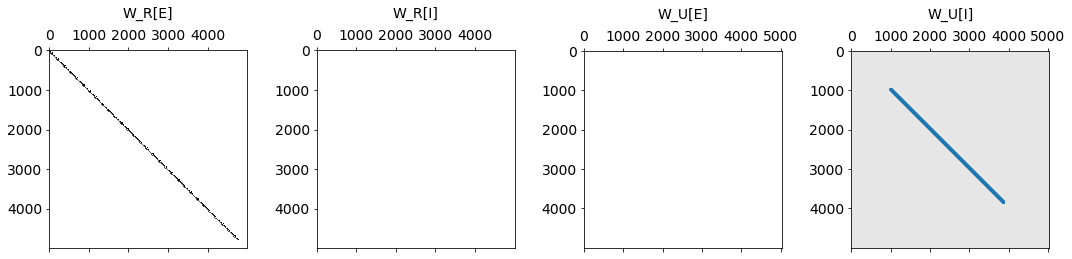

In [5]:
S.T = 0.3

W_R_E_E_F = [0.7e-5, 1.0e-5, 1.5e-5]
FQ_SPK_U = [0, 400]

rsps2 = []

for cw, w_r_e_e_f in enumerate(W_R_E_E_F):
    print(f'W_R_E_E_F = {w_r_e_e_f * 1e6} uS...')
    
    m = copy(M)
    m.W_R_E_E_F = w_r_e_e_f


    np.random.seed(seed=0)

    ## input weights
    w_u = {
        # localized inputs to trigger activation from start of chain
        'E': np.block([
            [ 0.01 * np.eye(m.N_L_E), np.zeros([m.N_L_E, m.N_N]) ],
            [ np.zeros([m.N_N - m.N_L_E, m.N_N + m.N_L_E]) ],
        ]),

        # global inhibitory inputs across chain
        'I': make_w_u_i_partial(m)
    }

    # inputs
    t = np.arange(0, S.T, S.DT)
    t_u = [.01, .013]
    t_mask = (t_u[0] <= t) & (t < t_u[1])

    
    # make ntwk
    L_MAX_V = 10  # max num links to plot voltage for

    rsps = []

    w_r = {
        'E': make_w_r_e(m),
        'I': make_w_r_i(m),
        'A': m.W_A * np.eye(m.N_N),
    }

    if cw == 0:
        fig, axs = plt.subplots(1, 4, figsize=(15, 4), tight_layout=True)
        axs[0].matshow(w_r['E'], vmin=0, vmax=10e-6, cmap='binary')
        axs[0].set_title('W_R[E]\n')
        axs[1].matshow(w_r['I'], vmin=0, vmax=10e-6, cmap='binary')
        axs[1].set_title('W_R[I]\n')

        axs[2].matshow(w_u['E'], vmin=0, vmax=10e-6, cmap='binary')
        axs[2].set_title('W_U[E]\n')
        axs[3].spy(w_u['I'], markersize=1)
        axs[3].set_title('W_U[I]\n')

        for ax in axs.flatten():
            ax.set_facecolor((.9, .9, .9))
            set_font_size(ax, 14)

    ## external currents
    i_ext = m.SGM_N/S.DT * np.random.randn(len(t), m.N_N) + m.I_EXT_B

    ## inp spks
    spks_u_base = np.zeros((len(t), m.N_L_E + m.N_N), dtype=int)

    # trigger inputs
    tmp = cc([np.ones(m.N_L_E, int), np.zeros(m.N_L_E*(t_mask.sum()-1))])
    spks_u_base[t_mask, :m.N_L_E] = tmp[np.random.permutation(len(tmp))].reshape(t_mask.sum(), m.N_L_E)

    for fq_idx, fq_spk_u in enumerate(FQ_SPK_U):

        ntwk = LIFNtwkG(
            c_m=m.C_M_E,
            g_l=m.G_L_E,
            e_l=m.E_L_E,
            v_th=m.V_TH_E,
            v_r=m.E_L_E,
            t_r=m.T_R_E,
            e_s={'E': m.E_E, 'I': m.E_I, 'A': m.E_A},
            t_s={'E': m.T_E, 'I': m.T_E, 'A': m.T_A},
            w_r=w_r,
            w_u=w_u)

        clamp = Generic(
            v={0: np.repeat(m.E_L_E, m.N_N)}, spk={})

        spks_u = spks_u_base.copy()
        spks_u[:, m.N_L_E:-(m.N_I)] = np.random.poisson(fq_spk_u * S.DT, (len(t), m.N_E))

        # run smln
        rsp = ntwk.run(dt=S.DT, clamp=clamp, i_ext=i_ext, spks_u=spks_u)
        rsp.spks_u = spks_u.copy()
        rsp.m = copy(m)

        rsps.append(rsp)
        
    rsps2.append(copy(rsps))

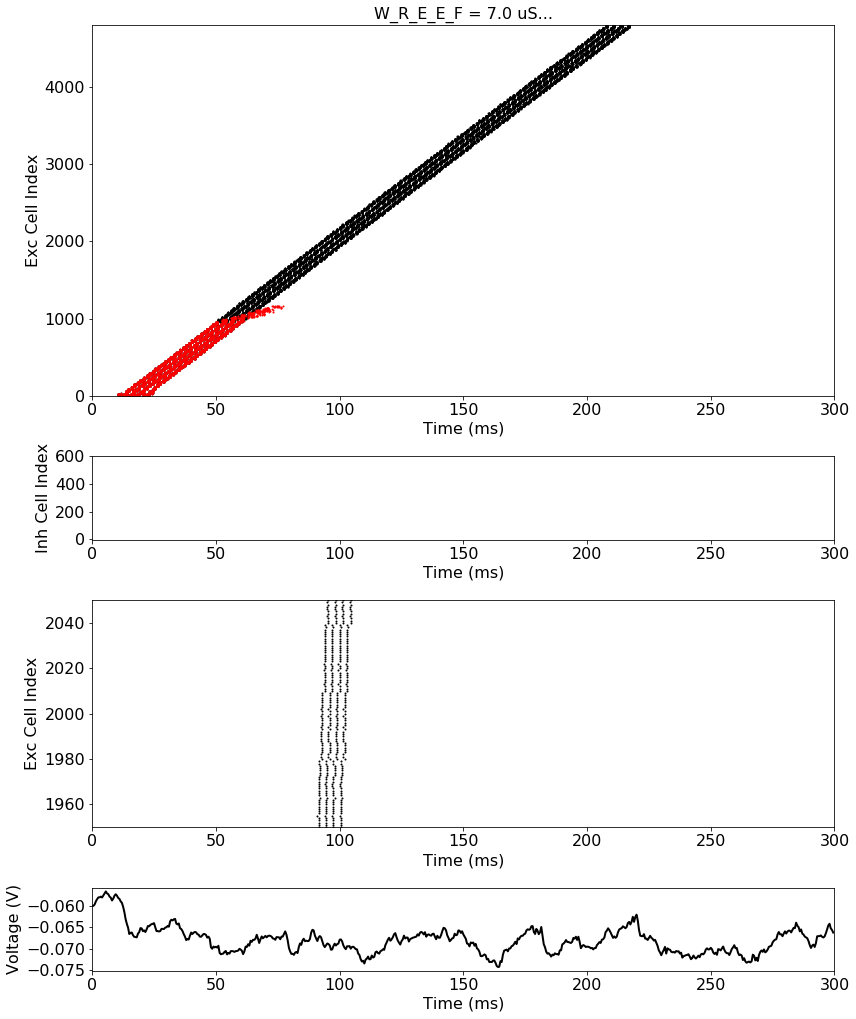

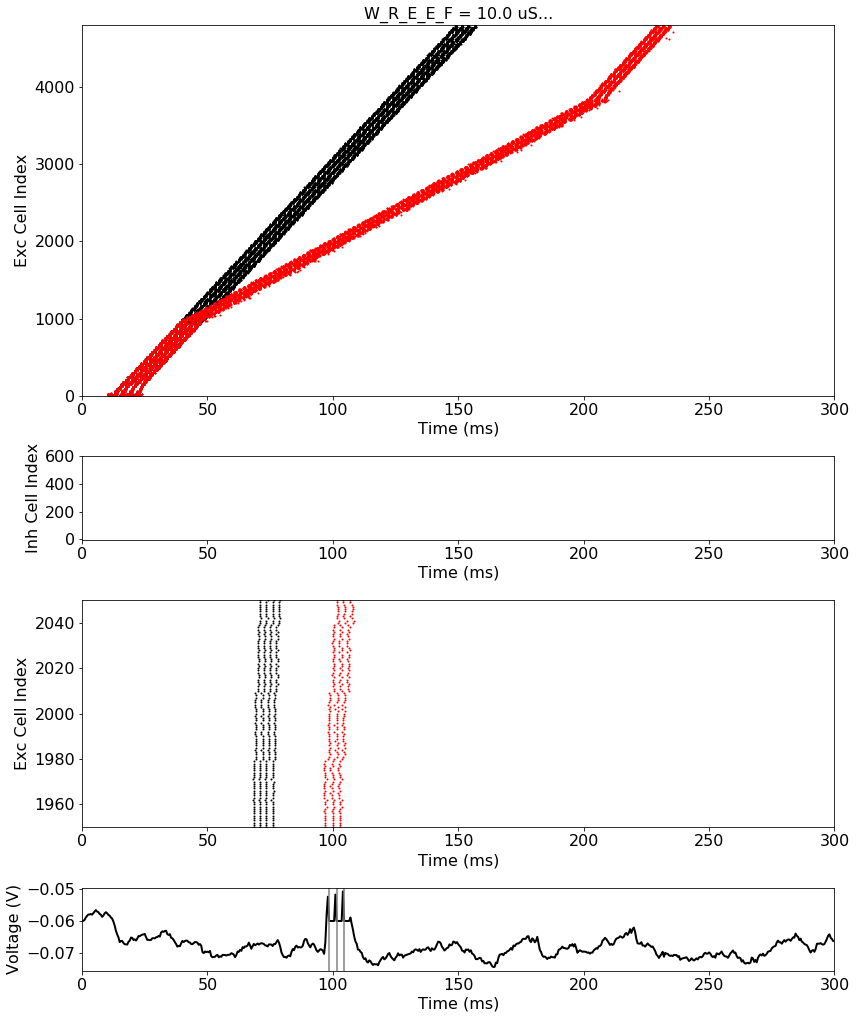

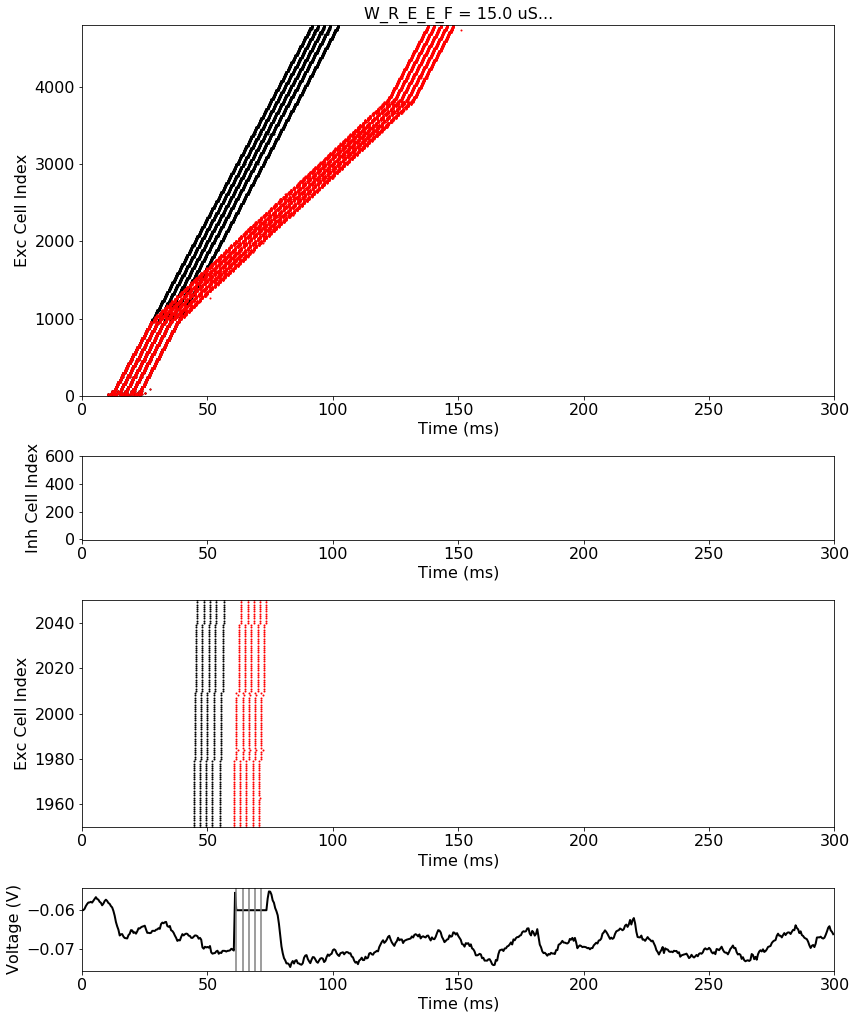

In [6]:
NRN_V_IDX = 2000

for w_r_e_e_f, rsps in zip(W_R_E_E_F, rsps2):

    inv_slope_rs = []

    gs = gridspec.GridSpec(8, 1)
    fig = plt.figure(figsize=(12, 16), tight_layout=True)
    axs = [fig.add_subplot(gs[1:4]), fig.add_subplot(gs[4]), fig.add_subplot(gs[5:7]), fig.add_subplot(gs[7:])]

    colors = ['k', 'r', 'green']
    inv_slopes = []

    for frq_idx, frq_res in enumerate(rsps):

        raster = np.stack([frq_res.spks_t, frq_res.spks_c])
        inh_raster = raster[:, raster[1, :] >= m.N_E]
        exc_raster = raster[:, raster[1, :] < m.N_E]

        axs[1].scatter(inh_raster[0, :] * 1000, inh_raster[1, :] - m.N_E + frq_idx * m.N_I,
                       s=1, c=colors[frq_idx], zorder=0, alpha=.8)
        axs[1].set_ylabel('Inh Cell Index')
        axs[1].set_xlabel('Time (ms)')
        axs[1].set_ylim(-1, 3 * m.N_I)

        axs[0].set_title(f'W_R_E_E_F = {w_r_e_e_f * 1e6} uS...')
        axs[0].set_ylim(-1, m.N_E)
        axs[0].set_ylabel('Exc Cell Index')
        axs[0].set_xlabel('Time (ms)')
        axs[2].set_ylim(1950, 2050)
        axs[2].set_ylabel('Exc Cell Index')
        axs[2].set_xlabel('Time (ms)')

        for l_cntr in range(m.N_L):
            link_window = (exc_raster[1, :] >= l_cntr * m.N_L_E) & (exc_raster[1, :] < ((l_cntr + 1) * m.N_L_E))
            link_spks = exc_raster[:, link_window]
            c = colors[frq_idx]
            axs[0].scatter(link_spks[0, :] * 1000, link_spks[1, :], s=1, c=c, zorder=0)
            axs[2].scatter(link_spks[0, :] * 1000, link_spks[1, :], s=1, c=c, zorder=0)
            #axs[0].plot(link_spks[0, :] * 1000, m.N_L_E * (link_spks[0, :] - icpt) * inv_slope, c='black')


    axs[-1].plot(1000*rsps[-1].t, rsps[-1].vs[:, NRN_V_IDX], c='k', lw=2)

    for spk_t in S.DT * rsps[-1].spks[:, NRN_V_IDX].nonzero()[0]:
        axs[-1].axvline(1000*spk_t, c='gray')

    axs[-1].set_xlabel('Time (ms)')
    axs[-1].set_ylabel('Voltage (V)')

    for ax in axs:
        ax.set_xlim(0, S.T * 1000)
        set_font_size(ax, 16)